In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating fluid cognition and neighbourhood poverty threshold
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_fluidcomp_uncorrected','reshist_addr1_adi_b138','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_b138'].median()
data.loc[data['reshist_addr1_adi_b138'] <= val, 'reshist_addr1_adi_b138_bin'] = 0
data.loc[data['reshist_addr1_adi_b138'] > val, 'reshist_addr1_adi_b138_bin'] = 1

In [4]:
data['nihtbx_fluidcomp_uncorrected_log']= np.log(data['nihtbx_fluidcomp_uncorrected'])
col='nihtbx_fluidcomp_uncorrected_log'
data['nihtbx_fluidcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [6]:
race, state

(Index(['Hispanic', 'Asian', 'Other', 'Black', 'White'], dtype='object'),
 Index(['california', 'colorado', 'connecticut', 'florida', 'maryland',
        'michigan', 'minnesota', 'missouri', 'newyork', 'oklahoma', 'oregon',
        'pennsylvania', 'southcarolina', 'utah', 'vermont', 'virginia',
        'wisconsin'],
       dtype='object'))

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_b138_bin.values
target_values = data.nihtbx_fluidcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting fluid cognition scores from neighbourhood poverty threshold

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1075 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


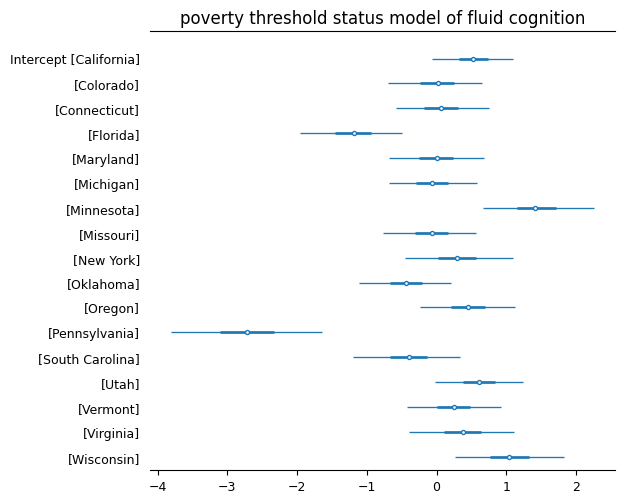

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty threshold status model of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_thresh_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/3826796285.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


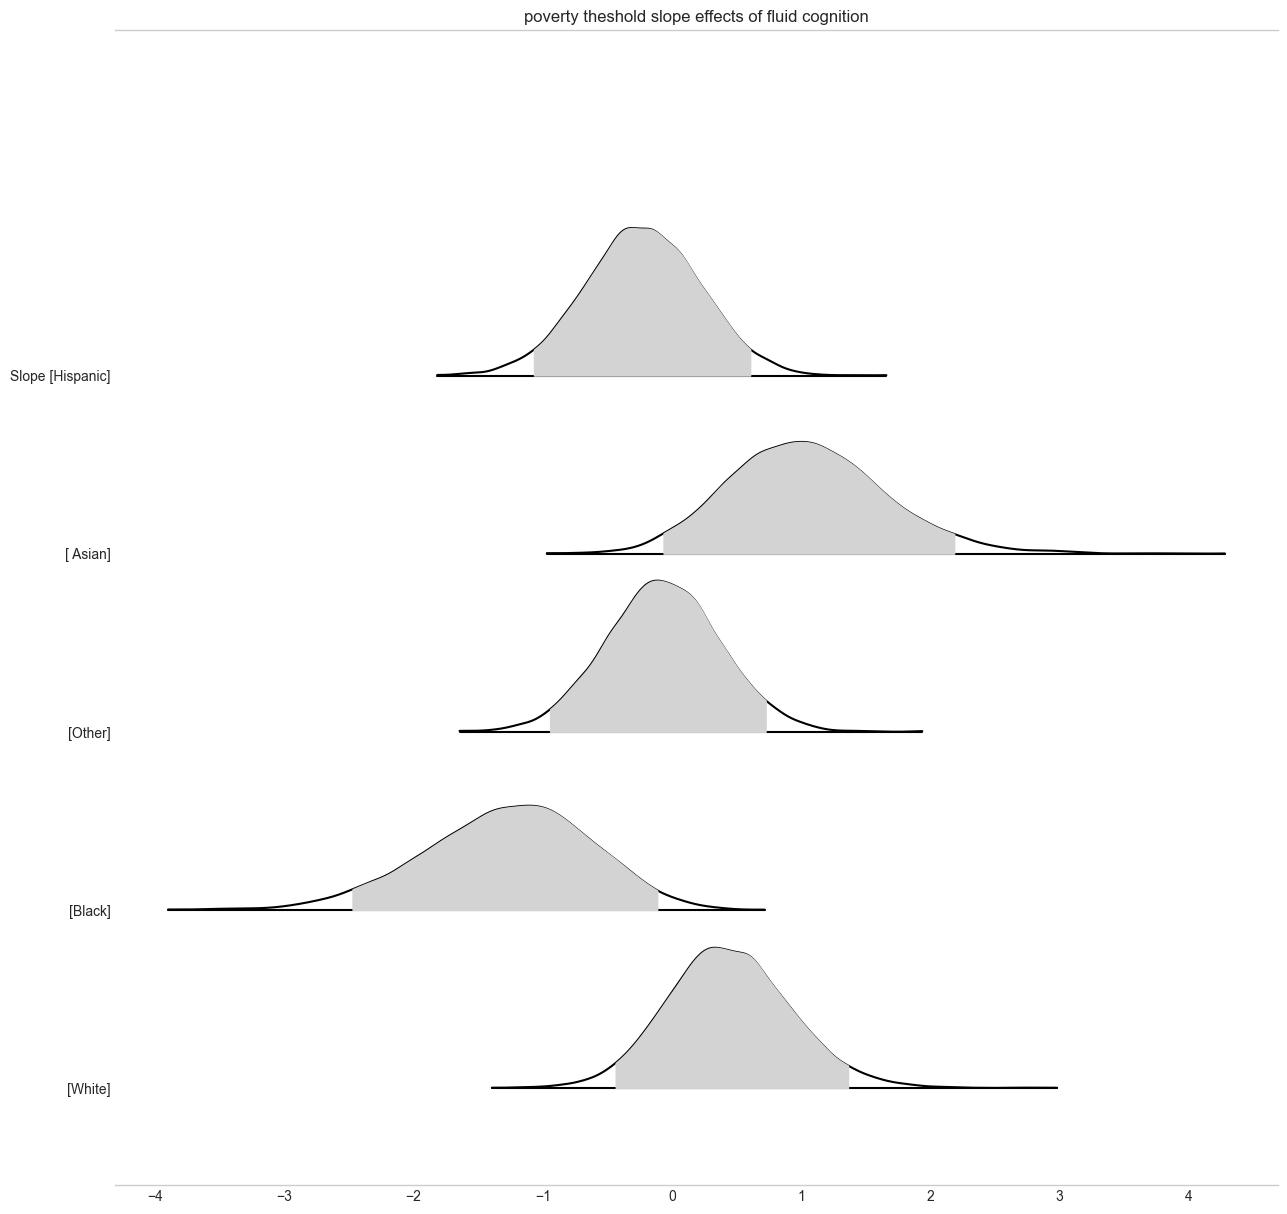

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty theshold slope effects of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_thresh_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.358655
r2_std    0.003443
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [16]:
# get race, state and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_b138_bin'],columns =['reshist_addr1_adi_b138_bin']).reset_index(drop=True)


In [17]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [18]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.193395  0.295918  0.141661   
                           Black           0.280387  0.137687  0.188542   
                           Hispanic        0.140213  0.172458  0.145298   
                           Other           0.175628  0.150893  0.144460   
                           White           0.232493  0.217274  0.197584   
1.0                        Asian           0.441415  0.676372  0.469542   
                           Black          -0.611722 -0.716256 -0.662270   
                           Hispanic       -0.242348 -0.165164 -0.200171   
                           Other          -0.077848 -0.192388 -0.216183   
                           White           0.078948  0.095108  0.079363   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.104083  0.153091  0.205936   
                           Black           0.209148  0.255654  0.161757   
                           Hispanic        0.130394  0.180465  0.145435   
                           Other           0.214864  0.203755  0.091353   
                           White           0.202612  0.253437  0.183112   
1.0                        Asian           0.192889  0.406121  0.044678   
                           Black          -0.790469 -0.709660 -0.705062   
                           Hispanic       -0.156466 -0.167646 -0.273550   
                           Other          -0.105181 -0.153614 -0.249618   
                           White           0.080433  0.188986  0.097079   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_b138_bin race_ethnicity                                 
0.0                        Asian           0.198606  0.216110  0.217016   
                           Black           0.251381  0.286243  0.146250   
                           Hispanic        0.193328  0.120668  0.255789   
                           Other           0.161104  0.155385  0.225974   
                           White           0.215280  0.214386  0.232527   
1.0                        Asian           0.346723  0.206353  0.480792   
                           Black          -0.706425 -0.729758 -0.680895   
                           Hispanic       -0.259667 -0.262328 -0.238367   
                           Other          -0.093908 -0.174441 -0.231583   
                           White           0.108028  0.046044  0.051933   

                                           pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_b138_bin race_ethnicity            ...                
0.0                        Asian           0.275101  ...     0.144901   
                           Black           0.222191  ...     0.082098   
                           Hispanic        0.202742  ...     0.132515   
                           Other           0.152944  ...     0.162972   
                           White           0.209354  ...     0.209398   
1.0                        Asian           0.205925  ...     0.217362   
                           Black          -0.656969  ...    -0.735104   
                           Hispanic       -0.196743  ...    -0.225012   
                           Other          -0.223718  ...    -0.141828   
                           White           0.114688  ...     0.111448   

                                           pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_b138_bin race_ethnicity                             
0.0                        Asian              0.143199     0.263445   
                           Black              0.117708     0.149476   
                           Hispanic           0.211872     0.233583   
                           Other              0.145732     0.172439   
                           White     

In [19]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_b138_bin  race_ethnicity
0.0                         Asian             0.222971
                            Black             0.173014
                            Hispanic          0.176242
                            Other             0.195795
                            White             0.213522
1.0                         Asian             0.381242
                            Black            -0.716006
                            Hispanic         -0.203441
                            Other            -0.159329
                            White             0.084486
dtype: float64

In [20]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.272928,0.417920,0.246804,0.132561,0.234231,0.154225,0.246104,0.212981,0.301602,0.252918,...,0.168138,0.166827,0.211895,0.271913,0.253633,0.454350,0.321073,0.273518,0.307383,0.165275
Black,-0.460408,-0.571416,-0.517961,-0.620921,-0.545930,-0.558038,-0.543968,-0.557430,-0.540600,-0.507851,...,-0.596495,-0.607033,-0.628436,-0.540087,-0.554464,-0.591257,-0.550447,-0.574772,-0.519822,-0.661432
Hispanic,-0.130016,-0.066027,-0.098730,-0.072234,-0.065429,-0.150522,-0.126653,-0.149868,-0.093267,-0.079441,...,-0.120031,-0.017031,-0.050090,-0.121487,-0.064367,-0.119831,-0.085904,-0.058803,-0.114039,-0.072337
Other,0.046985,-0.023328,-0.038572,0.052436,0.022384,-0.081695,0.031681,-0.012007,-0.006243,-0.038218,...,0.008282,0.001517,0.051186,0.005743,0.060197,-0.012828,0.017750,-0.014255,0.009378,0.013949
White,0.180796,0.176142,0.157780,0.161476,0.231737,0.154146,0.179170,0.157708,0.171723,0.177481,...,0.176420,0.132532,0.157245,0.170540,0.174678,0.157678,0.149748,0.184164,0.150168,0.161924


In [21]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [22]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_b138_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [23]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [24]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [25]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.249992,0.173264,0.181597,-0.006023,0.170931,0.161223,0.383271,0.160168,0.214216,0.106871,0.237625,-0.231547,0.110948,0.262149,0.207778,0.228215,0.326370
1,-0.084002,-0.076570,-0.255135,-0.383216,-0.453073,-0.205186,0.160358,-0.307535,-0.207134,-0.243074,0.044019,-0.785932,-0.347600,0.092153,0.073120,-0.183360,0.026969


In [26]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [27]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.222971,0.173014,0.176242,0.195795,0.213522
1,0.381242,-0.716006,-0.203441,-0.159329,0.084486


In [28]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [29]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [30]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [31]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [32]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [33]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [34]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [35]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [36]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [37]:
# get race, state, and neighbourhood poverty threshold columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [38]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.675805,1.489503,-0.593310,0.575470,-0.978131,-0.118107,...,1.011838,0.257677,0.552006,-0.370621,0.571895,-1.126551,-0.786925,0.946159,1.581659,0.048516
1,california,Asian,1,1067892,1.704307,0.720989,1.552945,-0.297435,0.883146,0.542888,...,-0.804479,-1.813531,-1.416106,0.785141,-0.800983,0.420988,1.439201,1.369288,0.241125,0.898764
2,california,Black,0,3168044,-1.604417,-1.933249,-0.687353,0.791280,-0.594750,1.163306,...,1.403336,0.784513,0.147067,-0.736229,0.457861,-0.862342,0.960244,-0.292777,0.492145,0.848873
3,california,Black,1,786431,-0.203392,-0.947692,-0.967078,0.126866,-0.068899,0.395159,...,0.872164,0.503515,-0.188088,-0.749493,-1.851312,0.831478,0.171671,-1.736278,-2.530902,0.104695
4,california,Hispanic,0,6779394,1.184990,1.121926,-0.908821,0.051747,0.862243,0.454804,...,0.510431,-0.059004,-0.005242,1.174920,-0.907433,0.425869,1.989004,0.045372,0.347779,0.784878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.181475,0.541582,0.810840,-0.024430,1.389428,1.409659,...,-1.505186,0.805230,0.281218,-0.809995,-2.283097,-0.530736,0.182544,-1.152235,-2.808014,-0.021190
137,wisconsin,Hispanic,0,88054,-0.975507,0.656811,0.579797,0.476323,0.211111,-0.377228,...,0.882562,0.054866,-0.421560,-0.264236,2.540308,0.874492,-0.197732,0.120923,0.201545,0.010039
138,wisconsin,Other,0,183517,0.596767,-0.127181,0.084485,-0.109890,0.750564,0.763619,...,0.466981,0.876454,0.483948,-0.403466,-0.542357,0.325801,-0.077535,1.878045,-0.446452,-1.180194
139,wisconsin,White,0,4001207,-1.318942,1.211588,0.074647,0.752181,1.103576,0.805865,...,0.318067,-0.592204,-0.183596,0.372058,0.989133,1.384671,0.914481,0.234835,1.339552,1.283780


In [39]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -5.186281e+05   
                          1                          1    1.820016e+06   
           Black          0                          2   -5.082864e+06   
                          1                          3   -1.599538e+05   
           Hispanic       0                          4    8.033511e+06   
...                                                                ...   
wisconsin  Black          1                          136 -8.644750e+04   
           Hispanic       0                          137 -8.589729e+04   
           Other          0                          138  1.095169e+05   
           White          0                          139 -5.277359e+06   
                          1                          140  4.015924e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.143079e+06   
                          1                          1    7.699381e+05   
           Black          0                          2   -6.124618e+06   
                          1                          3   -7.452943e+05   
           Hispanic       0                          4    7.605977e+06   
...                                                                ...   
wisconsin  Black          1                          136  2.146181e+04   
           Hispanic       0                          137  5.783486e+04   
           Other          0                          138 -2.333987e+04   
           White          0                          139  4.847814e+06   
                          1                          140  1.210383e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.553194e+05   
                          1                          1    1.658378e+06   
           Black          0                          2   -2.177565e+06   
                          1                          3   -7.605403e+05   
           Hispanic       0                          4   -6.161258e+06   
...                                                                ...   
wisconsin  Black          1                          136  3.213196e+04   
           Hispanic       0                          137  5.105344e+04   
           Other          0                          138  1.550442e+04   
           White          0                          139  2.986765e+05   
                          1                          140  1.680713e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.416293e+05   
                          1                          1   -3.176279e+05   
           Black          0                          2    2.506810e+06   
                          1                          3    9.977158e+04   
           Hispanic       0                          4    3.508147e+05   
...                                                                ...   
wisconsin  Black          1                          136 -9.681197e+02   
           Hispanic       0                          137  4.194217e+04   
           Other          0                          138 -2.016674e+04   
           White          0                          139  3.009631e+06   
                          1                          140 -8.394175e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -7.50

In [40]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-5.186281e+05,1.143079e+06,-4.553194e+05,4.416293e+05,-7.506402e+05,-9.063782e+04,1.505009e+05,8.752608e+05,9.609254e+05,3.168403e+02,...,7.765079e+05,1.977470e+05,4.236218e+05,-2.844229e+05,4.388850e+05,-8.645411e+05,-6.039043e+05,7.261042e+05,1.213801e+06,3.723252e+04
1,1.820016e+06,7.699381e+05,1.658378e+06,-3.176279e+05,9.431044e+05,5.797457e+05,1.355593e+06,6.012087e+05,2.029936e+06,1.229572e+06,...,-8.590966e+05,-1.936655e+06,-1.512249e+06,8.384463e+05,-8.553633e+05,4.495701e+05,1.536912e+06,1.462252e+06,2.574951e+05,9.597828e+05
2,-5.082864e+06,-6.124618e+06,-2.177565e+06,2.506810e+06,-1.884194e+06,3.685405e+06,3.734340e+06,3.351363e+06,-1.909001e+06,8.029636e+05,...,4.445830e+06,2.485371e+06,4.659150e+05,-2.332404e+06,1.450524e+06,-2.731936e+06,3.042096e+06,-9.275320e+05,1.559137e+06,2.689268e+06
3,-1.599538e+05,-7.452943e+05,-7.605403e+05,9.977158e+04,-5.418436e+04,3.107655e+05,-1.352636e+06,-8.732066e+05,-8.106914e+05,-1.051673e+06,...,6.858971e+05,3.959798e+05,-1.479181e+05,-5.894249e+05,-1.455929e+06,6.539003e+05,1.350074e+05,-1.365463e+06,-1.990380e+06,8.233523e+04
4,8.033511e+06,7.605977e+06,-6.161258e+06,3.508147e+05,5.845486e+06,3.083295e+06,6.285842e+06,-3.407297e+06,8.889090e+06,-2.063874e+05,...,3.460415e+06,-4.000135e+05,-3.553490e+04,7.965247e+06,-6.151846e+06,2.887131e+06,1.348424e+07,3.075940e+05,2.357733e+06,5.320999e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-8.644750e+04,2.146181e+04,3.213196e+04,-9.681197e+02,5.506027e+04,5.586197e+04,-4.154852e+04,-9.715121e+03,-9.997878e+04,-4.590393e+04,...,-5.964752e+04,3.190964e+04,1.114410e+04,-3.209849e+04,-9.047456e+04,-2.103201e+04,7.233869e+03,-4.566078e+04,-1.112760e+05,-8.397087e+02
137,-8.589729e+04,5.783486e+04,5.105344e+04,4.194217e+04,1.858917e+04,-3.321640e+04,5.853974e+04,1.188676e+05,2.656119e+04,1.600700e+05,...,7.771307e+04,4.831130e+03,-3.712009e+04,-2.326703e+04,2.236843e+05,7.700249e+04,-1.741105e+04,1.064780e+04,1.774685e+04,8.839974e+02
138,1.095169e+05,-2.333987e+04,1.550442e+04,-2.016674e+04,1.377412e+05,1.401370e+05,2.441043e+05,7.365240e+04,-1.631498e+05,3.381418e+05,...,8.569888e+04,1.608443e+05,8.881262e+04,-7.404290e+04,-9.953175e+04,5.979000e+04,-1.422902e+04,3.446533e+05,-8.193146e+04,-2.165856e+05
139,-5.277359e+06,4.847814e+06,2.986765e+05,3.009631e+06,4.415638e+06,3.224432e+06,4.629404e+06,3.214955e+05,1.538878e+06,2.783296e+06,...,1.272651e+06,-2.369530e+06,-7.346039e+05,1.488680e+06,3.957725e+06,5.540354e+06,3.659030e+06,9.396218e+05,5.359824e+06,5.136668e+06


In [41]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [42]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-5.186281e+05,1.143079e+06,-4.553194e+05,4.416293e+05,-7.506402e+05,-9.063782e+04,...,7.765079e+05,1.977470e+05,4.236218e+05,-2.844229e+05,4.388850e+05,-8.645411e+05,-6.039043e+05,7.261042e+05,1.213801e+06,3.723252e+04
1,california,Asian,1,1067892,1.820016e+06,7.699381e+05,1.658378e+06,-3.176279e+05,9.431044e+05,5.797457e+05,...,-8.590966e+05,-1.936655e+06,-1.512249e+06,8.384463e+05,-8.553633e+05,4.495701e+05,1.536912e+06,1.462252e+06,2.574951e+05,9.597828e+05
2,california,Black,0,3168044,-5.082864e+06,-6.124618e+06,-2.177565e+06,2.506810e+06,-1.884194e+06,3.685405e+06,...,4.445830e+06,2.485371e+06,4.659150e+05,-2.332404e+06,1.450524e+06,-2.731936e+06,3.042096e+06,-9.275320e+05,1.559137e+06,2.689268e+06
3,california,Black,1,786431,-1.599538e+05,-7.452943e+05,-7.605403e+05,9.977158e+04,-5.418436e+04,3.107655e+05,...,6.858971e+05,3.959798e+05,-1.479181e+05,-5.894249e+05,-1.455929e+06,6.539003e+05,1.350074e+05,-1.365463e+06,-1.990380e+06,8.233523e+04
4,california,Hispanic,0,6779394,8.033511e+06,7.605977e+06,-6.161258e+06,3.508147e+05,5.845486e+06,3.083295e+06,...,3.460415e+06,-4.000135e+05,-3.553490e+04,7.965247e+06,-6.151846e+06,2.887131e+06,1.348424e+07,3.075940e+05,2.357733e+06,5.320999e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-8.644750e+04,2.146181e+04,3.213196e+04,-9.681197e+02,5.506027e+04,5.586197e+04,...,-5.964752e+04,3.190964e+04,1.114410e+04,-3.209849e+04,-9.047456e+04,-2.103201e+04,7.233869e+03,-4.566078e+04,-1.112760e+05,-8.397087e+02
137,wisconsin,Hispanic,0,88054,-8.589729e+04,5.783486e+04,5.105344e+04,4.194217e+04,1.858917e+04,-3.321640e+04,...,7.771307e+04,4.831130e+03,-3.712009e+04,-2.326703e+04,2.236843e+05,7.700249e+04,-1.741105e+04,1.064780e+04,1.774685e+04,8.839974e+02
138,wisconsin,Other,0,183517,1.095169e+05,-2.333987e+04,1.550442e+04,-2.016674e+04,1.377412e+05,1.401370e+05,...,8.569888e+04,1.608443e+05,8.881262e+04,-7.404290e+04,-9.953175e+04,5.979000e+04,-1.422902e+04,3.446533e+05,-8.193146e+04,-2.165856e+05
139,wisconsin,White,0,4001207,-5.277359e+06,4.847814e+06,2.986765e+05,3.009631e+06,4.415638e+06,3.224432e+06,...,1.272651e+06,-2.369530e+06,-7.346039e+05,1.488680e+06,3.957725e+06,5.540354e+06,3.659030e+06,9.396218e+05,5.359824e+06,5.136668e+06


In [43]:
#final step of poststratification - by race & poverty threshold 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.439999  0.323550 -0.030732   
                           Black          -0.234177 -0.120707  0.187280   
                           Hispanic        0.897201  1.132356 -0.243116   
                           Other           0.917206  0.432401  0.231944   
                           White          -0.209336  0.899385 -0.741566   
1                          Asian           0.897573 -0.005386  1.078584   
                           Black          -0.248844 -0.412665 -0.955573   
                           Hispanic        0.612211 -0.667773  0.074029   
                           Other          -0.976272  0.599070 -0.245890   
                           White           0.076784  0.183082  0.112071   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian          -0.008227 -0.447462  0.606321   
                           Black           0.346981  0.178520  0.556706   
                           Hispanic       -0.135520  0.189395  0.285891   
                           Other          -0.305568 -0.114339 -0.768354   
                           White           0.420225 -0.165943  0.512134   
1                          Asian          -0.094944  0.672053  0.157906   
                           Black          -0.548122 -0.641954 -0.996610   
                           Hispanic       -0.560959  0.151693 -0.575901   
                           Other           0.332175  0.141040 -0.024047   
                           White           0.527531  0.612846  0.035565   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.908122 -0.123136 -0.376411   
                           Black           0.382925  0.195793  0.277640   
                           Hispanic        0.450505 -0.293507  0.547340   
                           Other           1.181426  0.574741 -0.335626   
                           White           0.202707  0.429975 -0.213569   
1                          Asian           0.819825  0.622367  0.527955   
                           Black          -0.788894 -0.489681 -0.850175   
                           Hispanic       -0.506726 -0.489238 -0.726562   
                           Other          -0.218386 -1.758728  0.067236   
                           White           0.248922  0.233843 -0.162082   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.610517  ...    -0.113980   
                           Black           0.406301  ...     0.278250   
                           Hispanic        0.127962  ...     0.297858   
                           Other           0.436436  ...    -0.526008   
                           White          -0.216809  ...     0.555710   
1                          Asian           0.449771  ...     0.400377   
                           Black          -0.576896  ...    -0.438344   
                           Hispanic        0.190852  ...    -1.108065   
                           Other           0.129587  ...    -0.407102   
                           White           0.096261  ...    -0.498884   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.045480     0.201968   
                           Black             -0.089369     0.103843   
                           Hispanic           0.177770     0.168288   
                           Other              0.801909     0.081673   
                           White     

In [44]:
#summarize race & poverty threshold poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.127475
                            Black             0.149031
                            Hispanic          0.209411
                            Other             0.103677
                            White             0.154351
1                           Asian             0.355733
                            Black            -0.653235
                            Hispanic         -0.251578
                            Other            -0.139123
                            White             0.078222
dtype: float64

In [45]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.185331
Black      -0.043747
Hispanic   -0.027541
Other      -0.043251
White       0.115717
dtype: float64

In [46]:
#for the lollipops
#final step poststrat - by state & ppoverty threshold
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.258263
                            colorado         0.165605
                            connecticut      0.184833
                            florida         -0.005587
                            maryland         0.164595
                            michigan         0.156796
                            minnesota        0.384836
                            missouri         0.157559
                            newyork          0.212758
                            oklahoma         0.100435
                            oregon           0.236585
                            pennsylvania    -0.229281
                            southcarolina    0.105384
                            utah             0.275960
                            vermont          0.214825
                            virginia         0.239212
                            wisconsin        0.331354
1                           california  

In [47]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.160389
colorado         0.137611
connecticut      0.184833
florida         -0.166352
maryland         0.056305
michigan         0.089316
minnesota        0.356782
missouri         0.044562
newyork          0.067197
oklahoma        -0.031105
oregon           0.149850
pennsylvania    -0.264892
southcarolina   -0.096373
utah             0.250874
vermont          0.202720
virginia         0.182657
wisconsin        0.350784
dtype: float64

In [48]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [49]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [50]:
ppc_pov_state_poststrat_summ_list

[0.2582625250931385,
 0.16560456833089296,
 0.1848325698741001,
 -0.00558740092553244,
 0.16459488035418585,
 0.15679612748132707,
 0.38483612927833916,
 0.1575594593572539,
 0.2127582148833297,
 0.10043481484473782,
 0.2365850469339901,
 -0.22928146824895435,
 0.10538356079607707,
 0.27596024873129,
 0.2148249824729945,
 0.23921177626702822,
 0.33135383544550073,
 0.08589082826897625,
 -0.08311816032603618,
 -0.2551351222813621,
 -0.3155667669347908,
 -0.5812047713915516,
 0.02748990082614882,
 0.2355210819638159,
 -0.045661846507340884,
 -0.05855329947923434,
 -0.06607120047654096,
 0.09565674134646818,
 -0.3507969068266699,
 -0.19270896882864083,
 0.007258213468273739,
 0.11316479582382315,
 0.04638725167452886,
 0.421511562197388]

In [51]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [52]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [53]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [54]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.258263,0.165605,0.184833,-0.005587,0.164595,0.156796,0.384836,0.157559,0.212758,0.100435,0.236585,-0.229281,0.105384,0.275960,0.214825,0.239212,0.331354
1,0.085891,-0.083118,-0.255135,-0.315567,-0.581205,0.027490,0.235521,-0.045662,-0.058553,-0.066071,0.095657,-0.350797,-0.192709,0.007258,0.113165,0.046387,0.421512


In [55]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.127475,0.149031,0.209411,0.103677,0.154351
1,0.355733,-0.653235,-0.251578,-0.139123,0.078222


In [56]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.05629438639477567,
  0.10337498093731526,
  0.020086670895933245,
  -0.29457272710596394,
  -0.07436353575465396,
  -0.009582411594533071,
  0.32712971787346756,
  -0.0849010962335254,
  0.00995248400223305,
  -0.1002656715112724,
  0.12472817780189373,
  -0.6910696044465112,
  -0.12137296497523499,
  0.1958033711696488,
  0.16789118150241084,
  0.028069337840396426,
  0.23453804056705058],
 [0.16262904107669687,
  0.1331747778547409,
  0.17961601161848084,
  -0.1658363273253947,
  0.05708178883805174,
  0.08889815075078335,
  0.35092145507796857,
  0.04028540775065377,
  0.06430463042057863,
  -0.032145715467201935,
  0.14093079975917927,
  -0.2571693350467258,
  -0.09276871641911758,
  0.25802802086507326,
  0.20486827251734674,
  0.17281975447254844,
  0.35832971355646615])

In [57]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

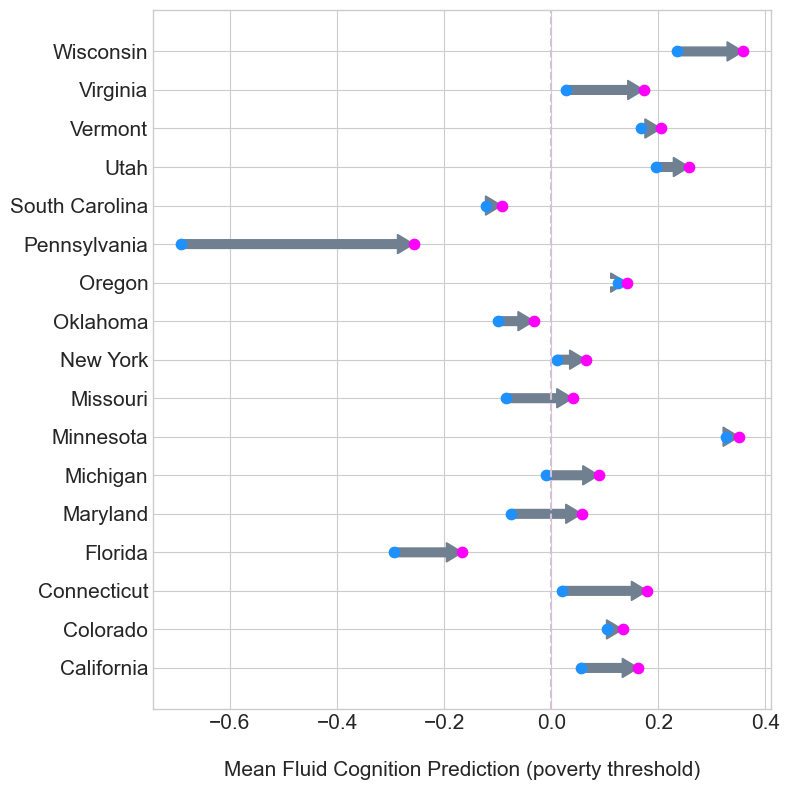

In [58]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (poverty threshold)',size=15,labelpad=20)
#plt.title('Mean Predictions of Fluid Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_fluid_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [59]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.2735266755866947,
  -0.5649395561828987,
  -0.09213849048797398,
  0.015966449027215286,
  0.16994919089410837],
 [0.18760685193585103,
  -0.04805087469004854,
  -0.028819365532559663,
  -0.0413571042014834,
  0.11491632708268235])

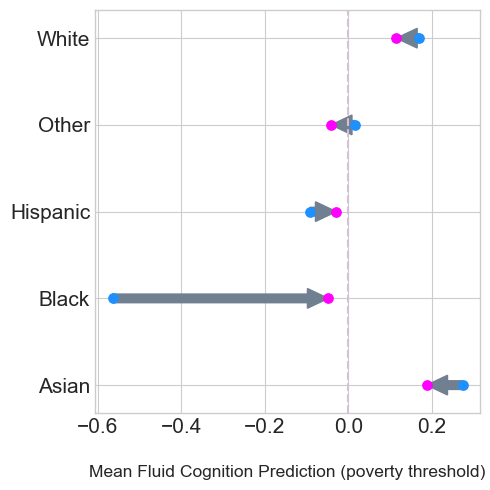

In [60]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (poverty threshold)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Fluid Cognition based on Poverty Threshold Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_thresh_fluid_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/3712042050.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/3712042050.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


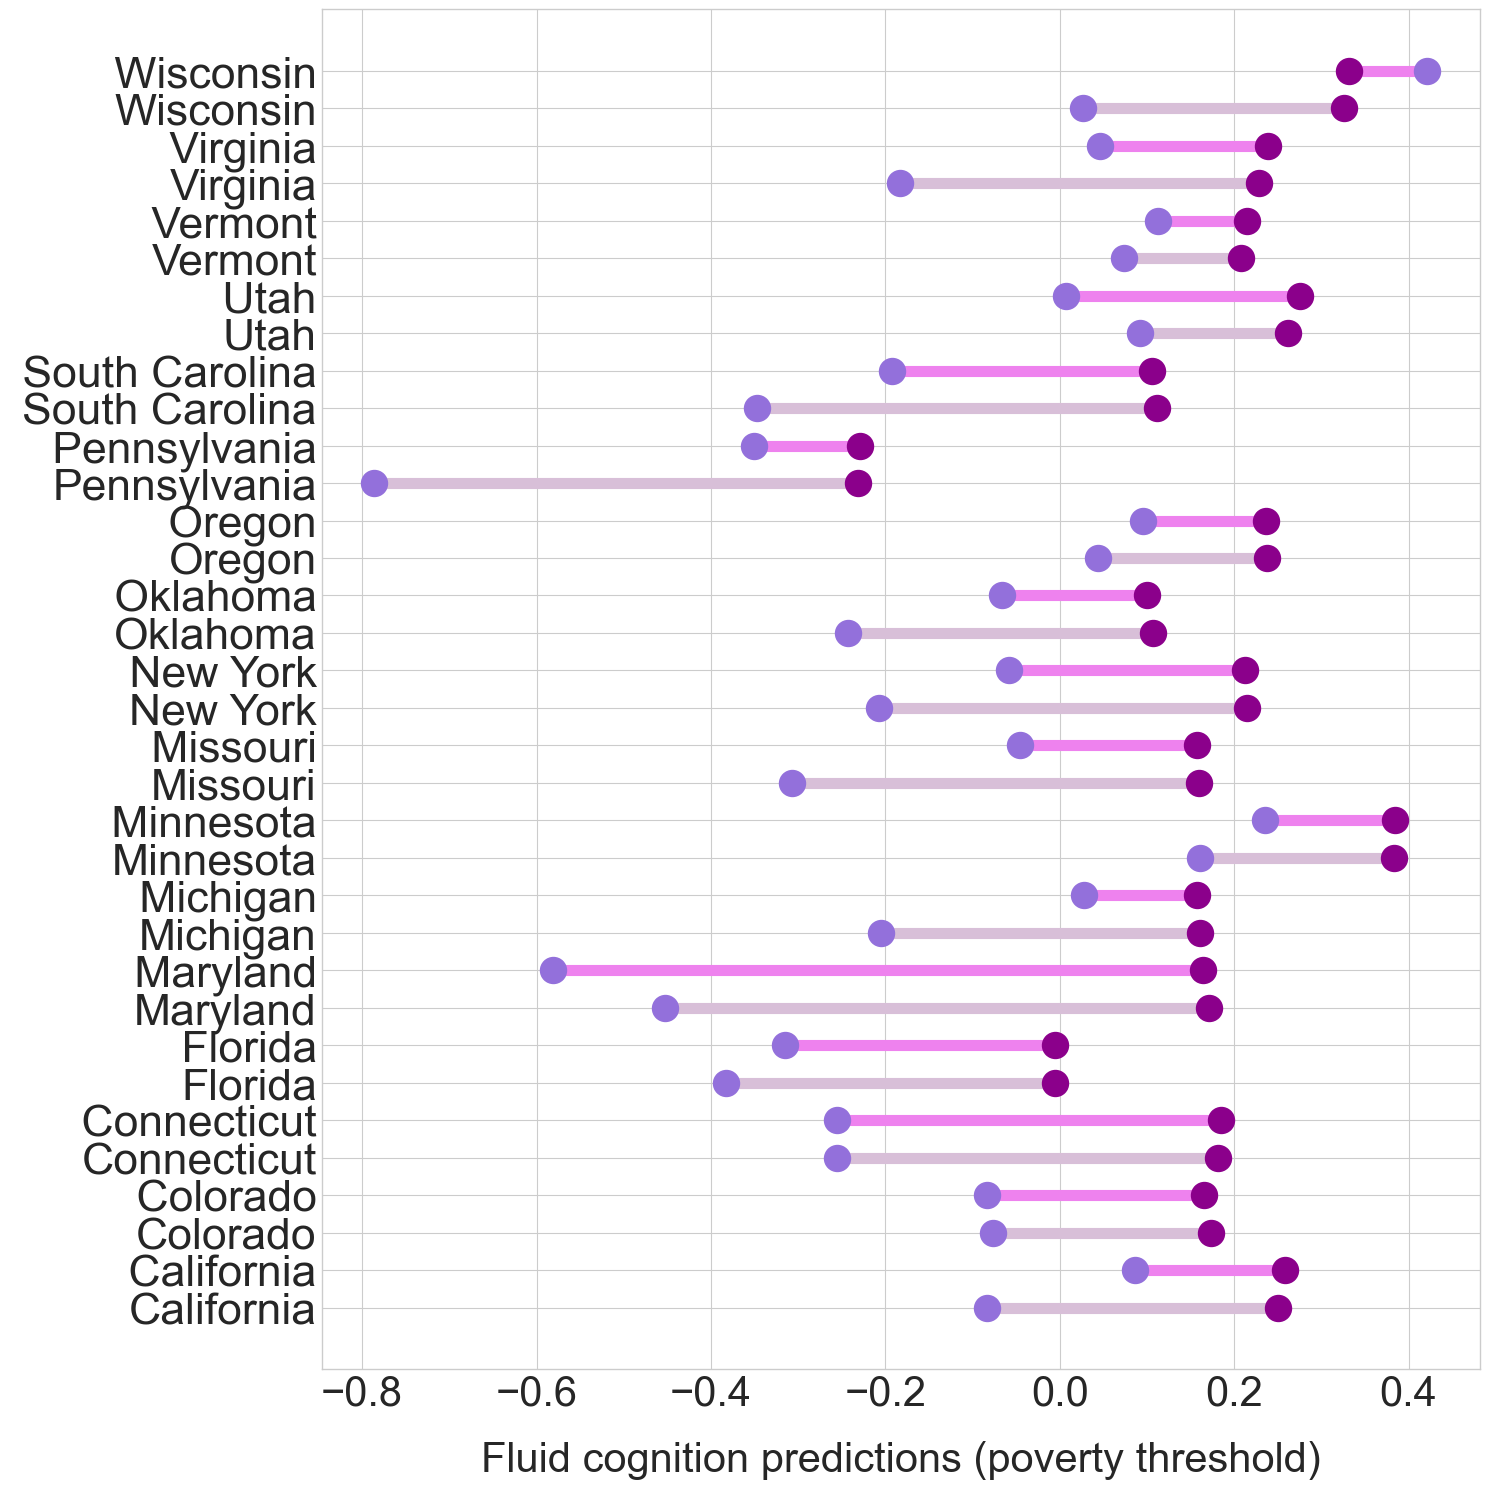

In [61]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov thresh', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov thresh', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov thresh', 'high pov thresh'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_fluid_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/2562581063.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/2562581063.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


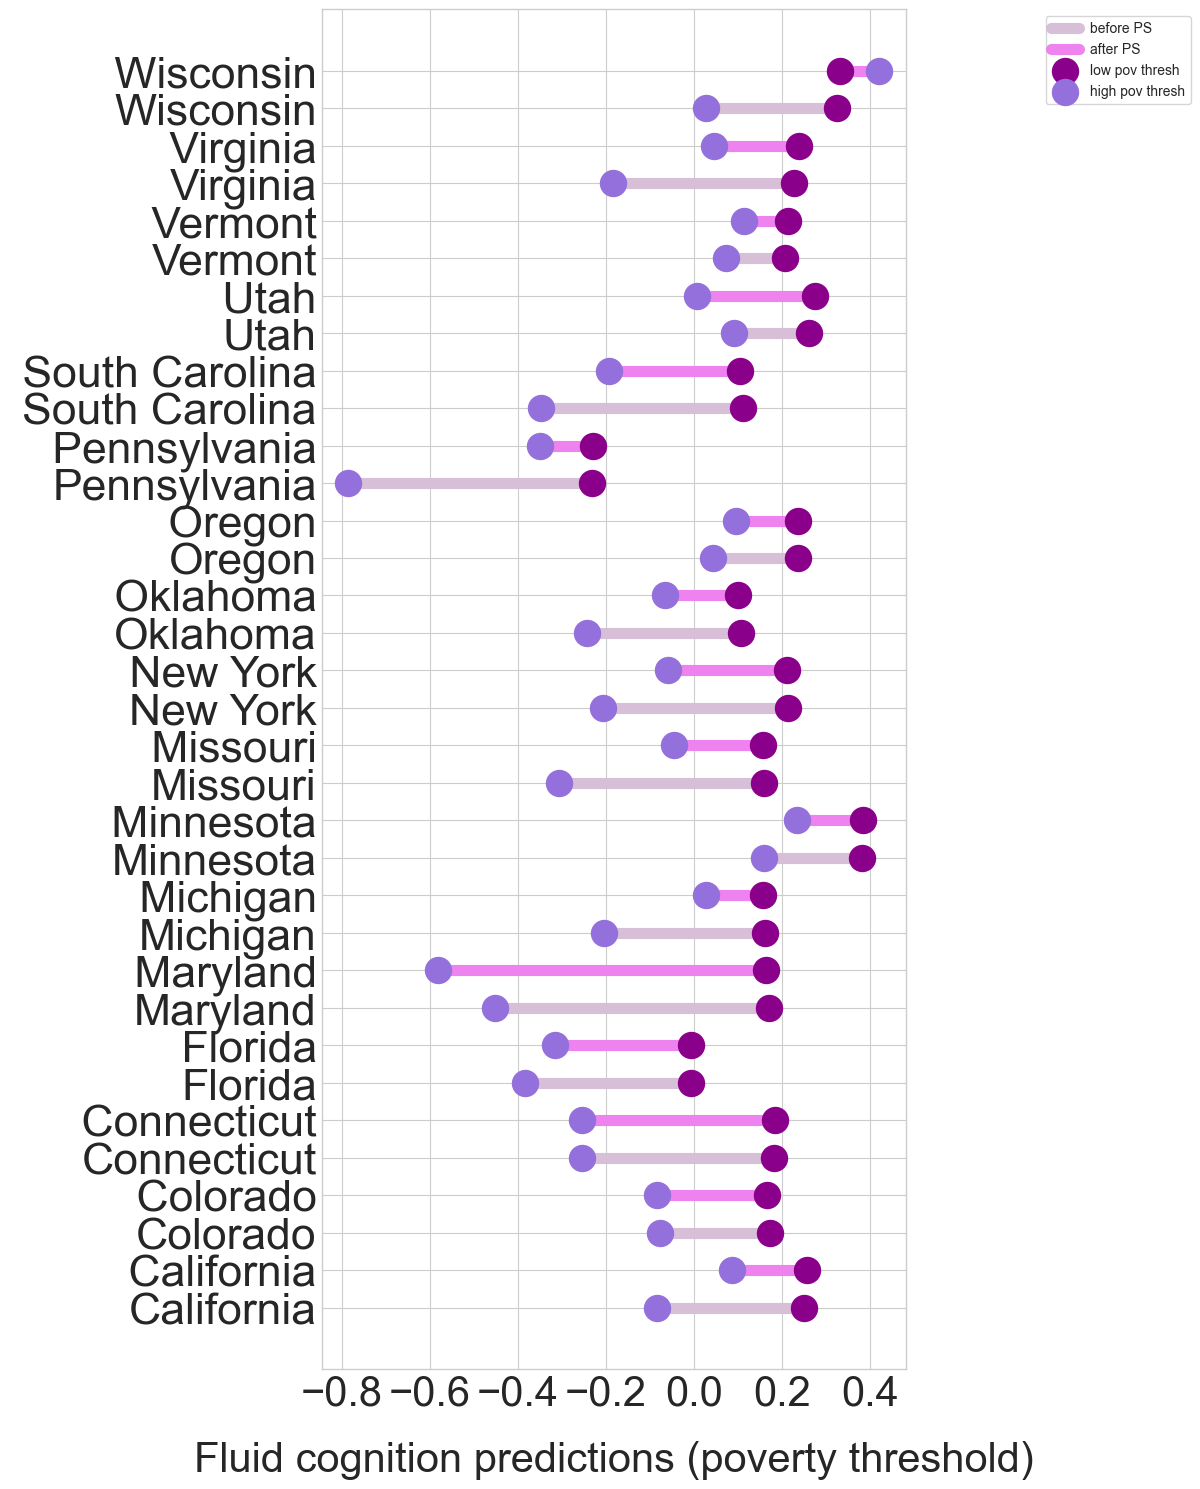

In [62]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov thresh', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov thresh', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
plt.legend(['before PS','after PS','low pov thresh', 'high pov thresh'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_fluid_ps_state_cognition_results_f5_legend.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/2999872641.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_65498/2999872641.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


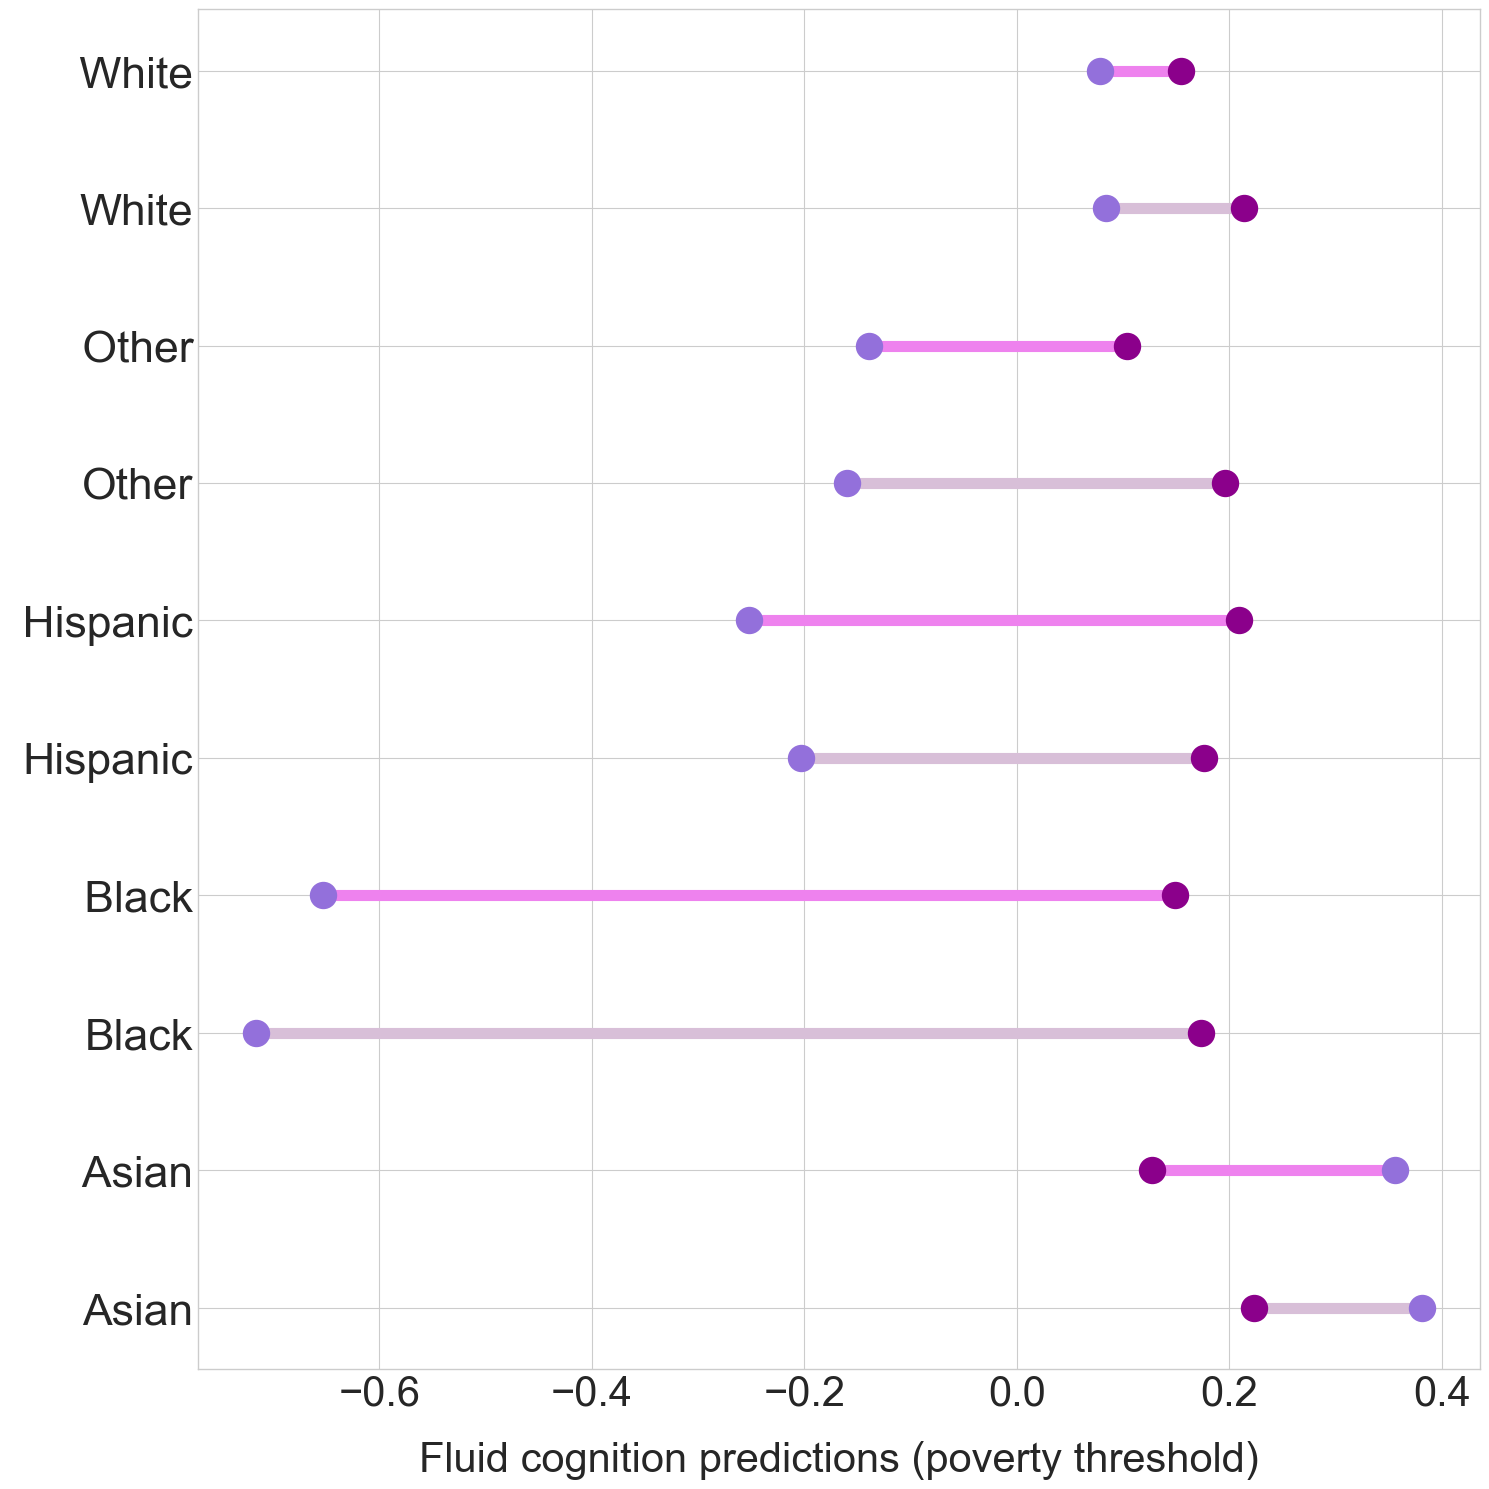

In [63]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov thresh', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov thresh', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Fluid cognition predictions (poverty threshold)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov thresh', 'high pov thresh'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_thresh_fluid_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()